In [1]:
import pandas as pd
import importlib
import sys
from tqdm import tqdm
import time
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
import contextily as cx
from datetime import datetime, timedelta
from scipy.signal import butter,filtfilt

In [2]:
from readers.InSAR import InSAR
from readers.GNSS import GNSS

In [3]:
insar = InSAR('data/time_series_Saarland_Orbit139_update.nc')
master_day = insar.get_master_day() # I think that we should completely discard gnss stations that do not have the reference day
insar_df = insar.get_df()
gnss = GNSS('data/selected_stations_dates.csv', master_day)
gnss_df = gnss.get_df()

Computing zscores and removing outliers for InSAR...


100%|██████████| 218637/218637 [00:59<00:00, 3650.71it/s]
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: BIWI does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: D525 does not have data for 6625. Using closest day 5920 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: LUX1 does not have data for 6625. Using closest day 6820 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: MOLV does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: MOUS does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/insar-super-resolution/readers/GNSS.py:94: UserWarning: OBER does not have data for 6625. Using closest day 6624 instead.
/cluster/home/mfrancesc/DSLab/

In [4]:
gnss.filter_signal(insar.sampling_freq/5)
df = gnss.take_derivative()

In [5]:
df

site   day  st_up_derivative(mm)
0      BAS4  5809              0.000000
1      BAS4  5810             -0.021151
2      BAS4  5811             -0.015528
3      BAS4  5812             -0.009291
4      BAS4  5813             -0.002464
...     ...   ...                   ...
49412  WALF  7353              0.007797
49413  WALF  7354             -0.000047
49414  WALF  7355             -0.007364
49415  WALF  7356             -0.014112
49416  WALF  7357             -0.020254

[49169 rows x 3 columns]

In [6]:
insar.df

longitude   latitude  day_5809  day_5833  day_5857  day_5881  \
0        6.519765  49.001122  0.443565  0.662923  0.938806  1.288714   
1        6.520702  49.001022 -1.232583 -0.594381  1.331016  0.888349   
2        6.520345  49.001186 -3.827611 -5.624767 -2.699052 -3.620394   
3        6.522241  49.000980 -0.477724 -0.685458  1.109011  0.921958   
4        6.522860  49.000912 -6.273820 -7.144917 -3.314945 -4.170864   
...           ...        ...       ...       ...       ...       ...   
218632   7.168369  49.499275 -3.583793 -1.124604 -0.724741 -2.007907   
218633   7.168715  49.499237  2.915712 -0.636469 -2.601358  0.042222   
218634   7.169266  49.499302 -0.057189  0.241462  1.185180 -1.868195   
218635   7.168502  49.499516 -3.028494 -3.264565 -2.341598 -4.402658   
218636   7.165560  49.499973  3.165419  0.410238  1.543840  5.054565   

        day_5905  day_5929  day_5953  day_5977  ...  day_7249  day_7261  \
0       0.972183  1.089221 -2.673817  1.161416  ...  0.952552 -0.026771   
1       0.039091  1.986124 -2.943490 -0.675613  ...  0.491814 -1.118202   
2      -2.690625 -0.858145  3.026767  0.796394  ...  0.047305 -2.291672   
3       1.527421  0.116671  0.655998  1.693059  ...  0.673722 -0.033307   
4      -0.023552 -1.455037 -2.394906 -0.549923  ... -3.768402 -1.988423   
...          ...       ...       ...       ...  ...       ...       ...   
218632 -2.343649 -3.115075 -1.588178 -2.363084  ...  3.642728  1.907474   
218633  6.741344 -0.704484 -0.470288  1.107459  ... -0.153611 -3.520806   
218634 -0.467016  0.886132 -0.369454 -0.564237  ...  1.402595  1.288679   
218635 -6.387621 -6.787593 -1.995903 -3.271259  ... -1.151303  3.083885   
218636  3.533217  3.405575  5.037633  1.667360  ... -3.841225 -3.745860   

        day_7273  day_7285  day_7297  day_7309  day_7321  day_7333  day_7345  \
0      -2.180646 -2.753477 -1.304375 -2.089222 -2.300007 -1.289456 -1.917608   
1       1.602648  2.468782  1.261807  2.251997  0.619658 -1.539544  1.381117   
2      -0.326629 -1.087338 -1.049406 -0.978085  1.596386  0.160267 -0.162504   
3       3.037169  1.984158  2.855781  1.700651  1.784802  1.082013  1.915553   
4      -1.405116 -2.605501 -2.723341 -0.004024  1.949367  1.487423 -2.063547   
...          ...       ...       ...       ...       ...       ...       ...   
218632 -0.438046  1.417581  2.277980 -0.105330  2.505167 -0.089690  0.438741   
218633 -1.432970  0.196284 -1.628919  1.408164  0.139583 -0.537895  1.461942   
218634 -1.304472  1.051492  0.571234 -0.198654  0.348298  0.141875  1.476270   
218635 -0.234255 -2.741057 -0.765156 -0.489101  0.035041  1.860275 -1.189990   
218636 -3.331721 -3.492187 -5.107456 -3.384679 -3.589324 -2.358755 -2.343112   

        day_7357  
0      -1.183348  
1      -0.743631  
2       0.121029  
3       1.952025  
4       2.471609  
...          ...  
218632  0.527512  
218633  0.536026  
218634  0.497766  
218635 -0.449847  
218636 -5.334354  

[218637 rows x 114 columns]

In [7]:
insar.df.isna().sum().sum()

210315

In [8]:
insar.filter_signal(insar.sampling_freq/5)

Filtering InSAR signal...
Using raw dataset


100%|██████████| 218637/218637 [01:39<00:00, 2186.84it/s]


longitude   latitude  day_5809  day_5833  day_5857  day_5881  \
0        6.519765  49.001122  0.581905  0.786763  1.150152  1.251448   
1        6.520702  49.001022 -0.528713 -0.114022  0.546459  0.971507   
2        6.520345  49.001186 -4.311403 -4.351644 -4.261602 -3.533927   
3        6.522241  49.000980 -0.242642  0.050640  0.544588  0.921738   
4        6.522860  49.000912 -6.412433 -5.780645 -4.290851 -2.728341   
...           ...        ...       ...       ...       ...       ...   
218632   7.168369  49.499275 -1.919670 -1.571479 -1.403852 -1.738064   
218633   7.168715  49.499237 -0.082981 -0.484307 -0.153773  1.002933   
218634   7.169266  49.499302  0.279584  0.188659 -0.103649 -0.378606   
218635   7.168502  49.499516 -2.486160 -2.613852 -3.472874 -4.884002   
218636   7.165560  49.499973  1.731891  1.768743  2.269584  3.183012   

        day_5905  day_5929  day_5953  day_5977  ...  day_7249  day_7261  \
0       0.773824  0.008304 -0.373568 -0.123761  ...  0.174712 -0.658256   
1       0.801750  0.142768 -0.648110 -1.351831  ... -0.007150  0.191427   
2      -1.878324  0.093399  1.124784  0.595827  ...  0.636604 -0.498667   
3       1.014827  0.962676  0.895414  0.681168  ...  0.921925  1.203297   
4      -1.964740 -1.742243 -0.946970  0.726512  ... -1.685972 -1.615504   
...          ...       ...       ...       ...  ...       ...       ...   
218632 -2.331111 -2.591904 -2.286482 -1.820578  ...  2.857008  1.906369   
218633  1.957422  1.793165  0.856187  0.192978  ... -1.904903 -2.069089   
218634 -0.386085 -0.177144 -0.033966 -0.110938  ...  0.527795  0.496435   
218635 -5.774873 -5.264849 -3.821406 -2.838106  ...  0.121515  0.402295   
218636  4.081030  4.447253  3.925792  2.522047  ... -2.715769 -3.206756   

        day_7273  day_7285  day_7297  day_7309  day_7321  day_7333  day_7345  \
0      -1.553277 -2.132189 -2.231399 -2.034556 -1.814382 -1.675734 -1.585182   
1       1.019987  1.916919  2.139932  1.509912  0.550854 -0.101579 -0.286032   
2      -1.502091 -1.560756 -0.832342  0.003840  0.436097  0.411371  0.201823   
3       1.789529  2.394521  2.511185  2.091316  1.594305  1.431028  1.569705   
4      -2.342524 -2.631186 -1.717662 -0.162500  0.889709  0.995577  0.692048   
...          ...       ...       ...       ...       ...       ...       ...   
218632  0.985332  0.794528  1.182015  1.456527  1.229330  0.724465  0.361881   
218633 -1.625415 -0.832250 -0.136098  0.212547  0.310135  0.387492  0.524703   
218634  0.370856  0.258632  0.196000  0.195658  0.305559  0.524846  0.735312   
218635 -0.116762 -1.054309 -1.348802 -0.646714  0.281392  0.566613  0.219458   
218636 -3.803778 -4.207793 -4.184907 -3.716639 -3.131609 -2.891579 -3.123056   

        day_7357  
0      -1.518945  
1      -0.269012  
2       0.078658  
3       1.719253  
4       0.617093  
...          ...  
218632  0.279235  
218633  0.629529  
218634  0.817447  
218635 -0.134833  
218636 -3.493153  

[218637 rows x 114 columns]

In [9]:
insar.filtered_df

longitude   latitude  day_5809  day_5833  day_5857  day_5881  \
0        6.519765  49.001122  0.581905  0.786763  1.150152  1.251448   
1        6.520702  49.001022 -0.528713 -0.114022  0.546459  0.971507   
2        6.520345  49.001186 -4.311403 -4.351644 -4.261602 -3.533927   
3        6.522241  49.000980 -0.242642  0.050640  0.544588  0.921738   
4        6.522860  49.000912 -6.412433 -5.780645 -4.290851 -2.728341   
...           ...        ...       ...       ...       ...       ...   
218632   7.168369  49.499275 -1.919670 -1.571479 -1.403852 -1.738064   
218633   7.168715  49.499237 -0.082981 -0.484307 -0.153773  1.002933   
218634   7.169266  49.499302  0.279584  0.188659 -0.103649 -0.378606   
218635   7.168502  49.499516 -2.486160 -2.613852 -3.472874 -4.884002   
218636   7.165560  49.499973  1.731891  1.768743  2.269584  3.183012   

        day_5905  day_5929  day_5953  day_5977  ...  day_7249  day_7261  \
0       0.773824  0.008304 -0.373568 -0.123761  ...  0.174712 -0.658256   
1       0.801750  0.142768 -0.648110 -1.351831  ... -0.007150  0.191427   
2      -1.878324  0.093399  1.124784  0.595827  ...  0.636604 -0.498667   
3       1.014827  0.962676  0.895414  0.681168  ...  0.921925  1.203297   
4      -1.964740 -1.742243 -0.946970  0.726512  ... -1.685972 -1.615504   
...          ...       ...       ...       ...  ...       ...       ...   
218632 -2.331111 -2.591904 -2.286482 -1.820578  ...  2.857008  1.906369   
218633  1.957422  1.793165  0.856187  0.192978  ... -1.904903 -2.069089   
218634 -0.386085 -0.177144 -0.033966 -0.110938  ...  0.527795  0.496435   
218635 -5.774873 -5.264849 -3.821406 -2.838106  ...  0.121515  0.402295   
218636  4.081030  4.447253  3.925792  2.522047  ... -2.715769 -3.206756   

        day_7273  day_7285  day_7297  day_7309  day_7321  day_7333  day_7345  \
0      -1.553277 -2.132189 -2.231399 -2.034556 -1.814382 -1.675734 -1.585182   
1       1.019987  1.916919  2.139932  1.509912  0.550854 -0.101579 -0.286032   
2      -1.502091 -1.560756 -0.832342  0.003840  0.436097  0.411371  0.201823   
3       1.789529  2.394521  2.511185  2.091316  1.594305  1.431028  1.569705   
4      -2.342524 -2.631186 -1.717662 -0.162500  0.889709  0.995577  0.692048   
...          ...       ...       ...       ...       ...       ...       ...   
218632  0.985332  0.794528  1.182015  1.456527  1.229330  0.724465  0.361881   
218633 -1.625415 -0.832250 -0.136098  0.212547  0.310135  0.387492  0.524703   
218634  0.370856  0.258632  0.196000  0.195658  0.305559  0.524846  0.735312   
218635 -0.116762 -1.054309 -1.348802 -0.646714  0.281392  0.566613  0.219458   
218636 -3.803778 -4.207793 -4.184907 -3.716639 -3.131609 -2.891579 -3.123056   

        day_7357  
0      -1.518945  
1      -0.269012  
2       0.078658  
3       1.719253  
4       0.617093  
...          ...  
218632  0.279235  
218633  0.629529  
218634  0.817447  
218635 -0.134833  
218636 -3.493153  

[218637 rows x 114 columns]

In [10]:
insar.filtered_df.isna().sum().sum()

210315

In [11]:
insar.take_derivative(use_filtered=True)

Taking derivative of InSAR signal...
Using filtered dataset


100%|██████████| 218637/218637 [00:13<00:00, 16590.31it/s]


longitude   latitude  day_5809  day_5833  day_5857  day_5881  \
0        6.519765  49.001122       0.0  0.008536  0.015141  0.004221   
1        6.520702  49.001022       0.0  0.017279  0.027520  0.017710   
2        6.520345  49.001186       0.0 -0.001677  0.003752  0.030320   
3        6.522241  49.000980       0.0  0.012220  0.020581  0.015715   
4        6.522860  49.000912       0.0  0.026324  0.062075  0.065105   
...           ...        ...       ...       ...       ...       ...   
218632   7.168369  49.499275       0.0  0.014508  0.006984 -0.013925   
218633   7.168715  49.499237       0.0 -0.016722  0.013772  0.048196   
218634   7.169266  49.499302       0.0 -0.003789 -0.012180 -0.011457   
218635   7.168502  49.499516       0.0 -0.005321 -0.035793 -0.058797   
218636   7.165560  49.499973       0.0  0.001535  0.020868  0.038059   

        day_5905  day_5929  day_5953  day_5977  ...  day_7249  day_7261  \
0      -0.019901 -0.031897 -0.015911  0.010409  ... -0.045904 -0.069414   
1      -0.007073 -0.027458 -0.032953 -0.029322  ... -0.028491  0.016548   
2       0.068983  0.082155  0.042974 -0.022040  ... -0.010088 -0.094606   
3       0.003879 -0.002173 -0.002803 -0.008927  ...  0.025010  0.023448   
4       0.031817  0.009271  0.033136  0.069728  ...  0.077554  0.005872   
...          ...       ...       ...       ...  ...       ...       ...   
218632 -0.024710 -0.010866  0.012726  0.019413  ... -0.014918 -0.079220   
218633  0.039770 -0.006844 -0.039041 -0.027634  ... -0.053705 -0.013682   
218634 -0.000312  0.008706  0.005966 -0.003207  ...  0.011186 -0.002613   
218635 -0.037120  0.021251  0.060143  0.040971  ...  0.029159  0.023398   
218636  0.037417  0.015259 -0.021728 -0.058489  ... -0.009162 -0.040916   

        day_7273  day_7285  day_7297  day_7309  day_7321  day_7333  day_7345  \
0      -0.074585 -0.048243 -0.008268  0.016404  0.018348  0.011554  0.007546   
1       0.069047  0.074744  0.018584 -0.052502 -0.079921 -0.054369 -0.015371   
2      -0.083619 -0.004889  0.060701  0.069682  0.036021 -0.002060 -0.017462   
3       0.048853  0.050416  0.009722 -0.034989 -0.041418 -0.013606  0.011556   
4      -0.060585 -0.024055  0.076127  0.129597  0.087684  0.008822 -0.025294   
...          ...       ...       ...       ...       ...       ...       ...   
218632 -0.076753 -0.015900  0.032291  0.022876 -0.018933 -0.042072 -0.030215   
218633  0.036973  0.066097  0.058013  0.029054  0.008132  0.006446  0.011434   
218634 -0.010465 -0.009352 -0.005219 -0.000028  0.009158  0.018274  0.017539   
218635 -0.043255 -0.078129 -0.024541  0.058507  0.077342  0.023768 -0.028930   
218636 -0.049752 -0.033668  0.001907  0.039022  0.048752  0.020003 -0.019290   

        day_7357  
0       0.005520  
1       0.001418  
2      -0.010264  
3       0.012462  
4      -0.006246  
...          ...  
218632 -0.006887  
218633  0.008735  
218634  0.006845  
218635 -0.029524  
218636 -0.030841  

[218637 rows x 114 columns]

In [12]:
insar.derivative_df

longitude   latitude  day_5809  day_5833  day_5857  day_5881  \
0        6.519765  49.001122       0.0  0.008536  0.015141  0.004221   
1        6.520702  49.001022       0.0  0.017279  0.027520  0.017710   
2        6.520345  49.001186       0.0 -0.001677  0.003752  0.030320   
3        6.522241  49.000980       0.0  0.012220  0.020581  0.015715   
4        6.522860  49.000912       0.0  0.026324  0.062075  0.065105   
...           ...        ...       ...       ...       ...       ...   
218632   7.168369  49.499275       0.0  0.014508  0.006984 -0.013925   
218633   7.168715  49.499237       0.0 -0.016722  0.013772  0.048196   
218634   7.169266  49.499302       0.0 -0.003789 -0.012180 -0.011457   
218635   7.168502  49.499516       0.0 -0.005321 -0.035793 -0.058797   
218636   7.165560  49.499973       0.0  0.001535  0.020868  0.038059   

        day_5905  day_5929  day_5953  day_5977  ...  day_7249  day_7261  \
0      -0.019901 -0.031897 -0.015911  0.010409  ... -0.045904 -0.069414   
1      -0.007073 -0.027458 -0.032953 -0.029322  ... -0.028491  0.016548   
2       0.068983  0.082155  0.042974 -0.022040  ... -0.010088 -0.094606   
3       0.003879 -0.002173 -0.002803 -0.008927  ...  0.025010  0.023448   
4       0.031817  0.009271  0.033136  0.069728  ...  0.077554  0.005872   
...          ...       ...       ...       ...  ...       ...       ...   
218632 -0.024710 -0.010866  0.012726  0.019413  ... -0.014918 -0.079220   
218633  0.039770 -0.006844 -0.039041 -0.027634  ... -0.053705 -0.013682   
218634 -0.000312  0.008706  0.005966 -0.003207  ...  0.011186 -0.002613   
218635 -0.037120  0.021251  0.060143  0.040971  ...  0.029159  0.023398   
218636  0.037417  0.015259 -0.021728 -0.058489  ... -0.009162 -0.040916   

        day_7273  day_7285  day_7297  day_7309  day_7321  day_7333  day_7345  \
0      -0.074585 -0.048243 -0.008268  0.016404  0.018348  0.011554  0.007546   
1       0.069047  0.074744  0.018584 -0.052502 -0.079921 -0.054369 -0.015371   
2      -0.083619 -0.004889  0.060701  0.069682  0.036021 -0.002060 -0.017462   
3       0.048853  0.050416  0.009722 -0.034989 -0.041418 -0.013606  0.011556   
4      -0.060585 -0.024055  0.076127  0.129597  0.087684  0.008822 -0.025294   
...          ...       ...       ...       ...       ...       ...       ...   
218632 -0.076753 -0.015900  0.032291  0.022876 -0.018933 -0.042072 -0.030215   
218633  0.036973  0.066097  0.058013  0.029054  0.008132  0.006446  0.011434   
218634 -0.010465 -0.009352 -0.005219 -0.000028  0.009158  0.018274  0.017539   
218635 -0.043255 -0.078129 -0.024541  0.058507  0.077342  0.023768 -0.028930   
218636 -0.049752 -0.033668  0.001907  0.039022  0.048752  0.020003 -0.019290   

        day_7357  
0       0.005520  
1       0.001418  
2      -0.010264  
3       0.012462  
4      -0.006246  
...          ...  
218632 -0.006887  
218633  0.008735  
218634  0.006845  
218635 -0.029524  
218636 -0.030841  

[218637 rows x 114 columns]

In [13]:
insar.derivative_df.isna().sum().sum()

210315

### Plot vertical displacement and position on the map

In [14]:
# We will focus on a particular site
site_name = "D930"
site_df = gnss_df[gnss_df["site"] == site_name]
site_gdf = gnss.get_sites_gdf().loc[site_name]
site_lat = site_gdf["_latitude(deg)"]
site_long = site_gdf["_longitude(deg)"]

In [15]:
# and a particular k
k = 5
selected_insar = insar.get_k_closest_points(site_long, site_lat, k = k) # takes ~30sec
selected_insar_derivative = insar.get_k_closest_points(site_long, site_lat, k = k, dataset='derivative')

Searching for 5 nearest InSAR datapoints


100%|██████████| 218637/218637 [00:35<00:00, 6171.83it/s]


Searching for 5 nearest InSAR datapoints


100%|██████████| 218637/218637 [00:35<00:00, 6173.51it/s]


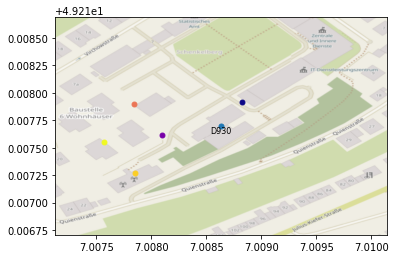

In [16]:
ax = plt.gca()
# plot gnss station
bbox = gnss.get_bbox_around_site(site_name)
gpd.GeoSeries(bbox).plot(ax=ax, color='green', alpha=0) #this is just to make image show everything within bounds
gpd.GeoSeries(site_gdf.geometry).plot(ax=ax, markersize=25)
ax.text(site_gdf.geometry.x,
        site_gdf.geometry.y,
        site_gdf.name,
        fontsize=8, ha='center', va='top')
# plot k nearest insar points
cmap = mpl.colormaps['plasma']
d = selected_insar["distance(m)"]
d = (d - d.min())/(d.max()-d.min())
for i in range(k):
    row = selected_insar.iloc[i,:]
    gpd.GeoSeries(Point(row["longitude"], row["latitude"])).plot(ax=ax, markersize=24, color=cmap(d.iloc[i]))
cx.add_basemap(ax=ax, crs = 'EPSG:4326', attribution='')

In [17]:
def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings
    
    https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

def plot_gnss_with_insar_points(selected_insar, selected_insar_distances, site_df, value_to_show = 'st_up_no_year(mm)', gnss_only_matching_days = False, ax = None):
    # Get site data
    site_name = site_df["site"].iloc[0]
    # Get insar data
    insar_days = [int(col[-4:]) for col in selected_insar.columns if col.startswith("day")]
    selected_insar_data = selected_insar[[col for col in selected_insar.columns if col.startswith("day")]]
    assert len(selected_insar_data.columns) == 112
    
    # Get gnss data
    if gnss_only_matching_days:
        selected_gnss_data = site_df[site_df['day'].isin(insar_days)]
        gnss_days = selected_gnss_data["day"].values
        selected_gnss_data = selected_gnss_data[value_to_show]
    else:
        selected_gnss_data = site_df[value_to_show]
        gnss_days = site_df["day"]
        
    # Make axis and figure if there are none
    ax = plt.gca() if ax is None else ax
    fig = plt.gcf()
        
    # Plot data
    fig.set_figwidth(20)
    lc = multiline([insar_days]*5, selected_insar_data.values, selected_insar_distances, cmap='plasma', lw=1.5)
    axcb = fig.colorbar(lc)
    ax.plot(gnss_days, selected_gnss_data, lw=1.5, c="green", alpha= 0.6,label = f"GNSS_{site_name}") # without outlier removal gnss reaches 140 at some point
    axcb.set_label(f'Distance from {site_name} in meters')
    ax.set_title(f'{k} closest InSar data points to {site_name}')
    ax.set_ylabel("Vertical displacement in mm")
    ax.set_xlabel("Days of measurements")
    ax.legend()
    
    fig.tight_layout()

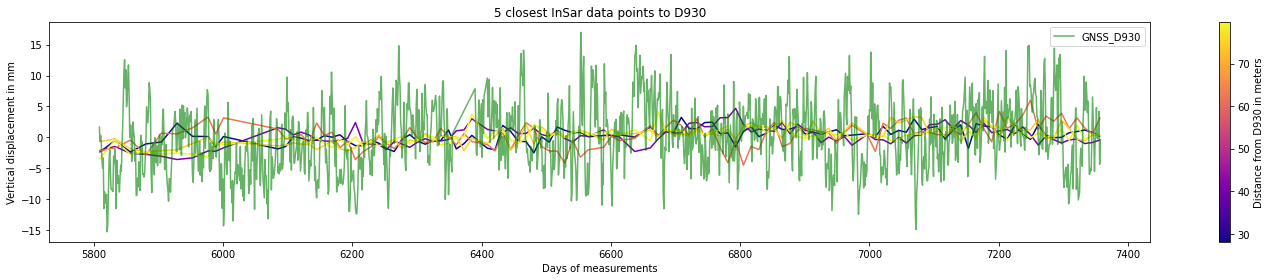

In [18]:
plot_gnss_with_insar_points(selected_insar,selected_insar["distance(m)"], site_df)

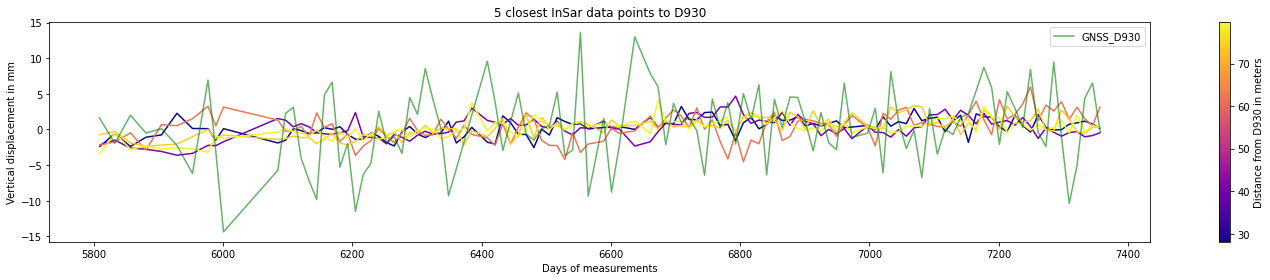

In [19]:
plot_gnss_with_insar_points(selected_insar, selected_insar["distance(m)"],site_df, gnss_only_matching_days = True)

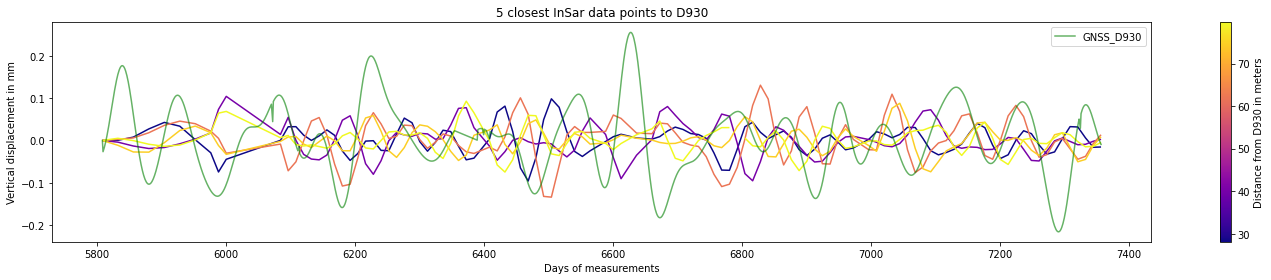

In [20]:
plot_gnss_with_insar_points(selected_insar_derivative,selected_insar["distance(m)"], site_df, value_to_show='st_up_derivative(mm)')

In [ ]:
# TODO: Check if it works with the longer GNSS dataset and think about missing values in the InSAR